In [3]:
import matplotlib.pyplot as plt
import numpy as np
import dsdl
import numpy.random
from typing import Callable, List
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATASETS = ['a1a', 'mushrooms', 'a6a', 'w1a', 'w5a', 'ionosphere']
METHODS = ['SGD', 'AdaSpider', 'Spider', 'SpiderBoost', 'SVRG', 'AdaGrad', 'AdaSVRG']

# Logistic regression

In [5]:
from src.logistic_regression.log_reg_gradient import log_reg_gradient
from src.logistic_regression.sigmoid import sigmoid
from src.logistic_regression.stochastic_gradient import stochastic_gradient

from src.optimizers.Optimizer import Optimizer

In [6]:
def get_data(dataset_name: str):
    """
    :param dataset_name: Name of the dataset from dsdl module.
    :return: (X, y) train and target data.
    """
    ds = dsdl.load(dataset_name)
    X, y = ds.get_train()
    X = X.toarray()
    y = y.reshape(-1, 1)
    return X, y

def build_model(X, y):
    """
    Builds
    :param X: shape=(N, D). Train data
    :param y: shape=(N, 1). Target data
    :return: shape=(N, D+1). Built model for logistic regression.
    """
    return np.c_[np.ones((y.shape[0], 1)), X]

def get_initial_weights(tx):
    """
    Returns weights initialized from the uniform distribution [0, 1].
    :param tx: shape=(N, D). Build model
    :return: shape=(D, 1) Initial weights
    """
    np.random.seed(2022)
    return np.ones(shape=(tx.shape[1], 1))  # low=0, high=1,

def test_method(method: Optimizer,
                dataset_name: str,
                max_iter: int,
                *parameters) -> List:
        """
        :param method: Optimization method implementation from src optimizers module.
        :param dataset_name: Name of the dataset from dsdl module.
        :param max_iter: Number of iterations to test.
        :param parameters optional: Dataclass containing parameters used int optimization method.
        :return: List of gradients from optimization method.
        """
        X, y = get_data(dataset_name)
        tx = build_model(X, y)
        initial_weights = get_initial_weights(tx)

        gradients = method.optimize(initial_weights, tx, y, max_iter)
        return [np.linalg.norm(grad, 2) for grad in gradients]

In [7]:
from src.optimizers.SGD import SGD
from src.optimizers.AdaSpider import AdaSpider
from src.optimizers.Spider import Spider
from src.optimizers.SpiderBoost import SpiderBoost
from src.optimizers.SVRG import SVRG
from src.optimizers.AdaGrad import AdaGrad
from src.optimizers.AdaSVRG import AdaSVRG

In [12]:
N_ORACLE_CALLS = 10

METHODS = [
    SGD(lambda_=0.01, q=N_ORACLE_CALLS),
    # AdaSpider(q=N_ORACLE_CALLS),
    Spider(n_0 = 1, epsilon=0.01, q=N_ORACLE_CALLS),
    SpiderBoost(q=N_ORACLE_CALLS),
    # SVRG(lambda_=0.01, q=N_ORACLE_CALLS),
    # AdaGrad(lambda_=0.1, epsilon= 0.001, q=N_ORACLE_CALLS),
    # AdaSVRG(lambda_=0.1, q=N_ORACLE_CALLS)
]

### Plot

Dataset a1a
Method SGD
Method Spider
Method SpiderBoost


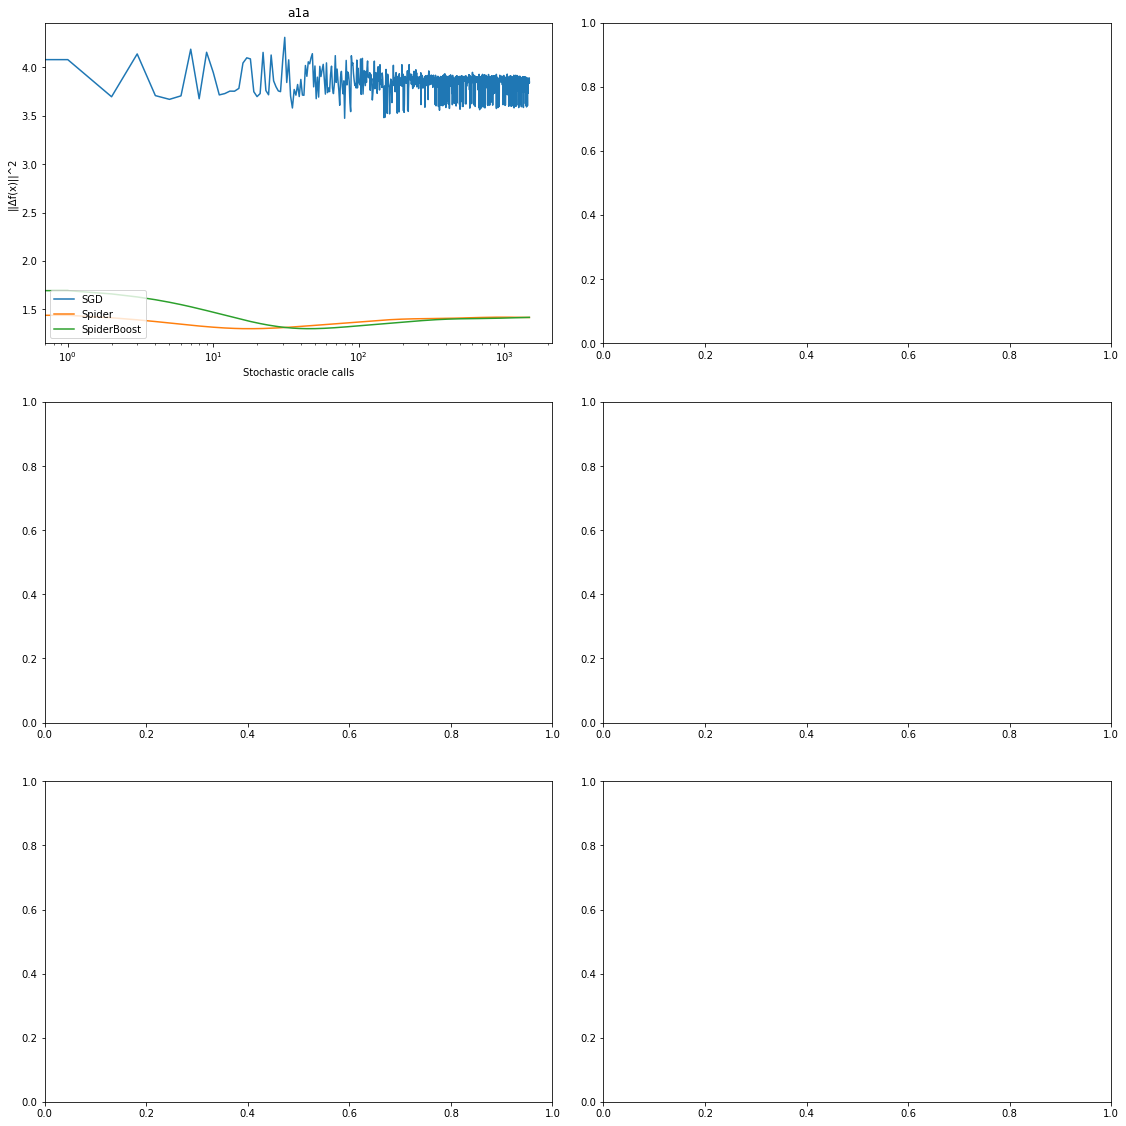

In [14]:
ITERATIONS = 15000

def plot_data():
    # Write your code to make 4x4 panel here
    X_LABEL = "Stochastic oracle calls"
    Y_LABEL = "||\u0394f(x)||^2"

    fig, ax = plt.subplots(3, 2, figsize=(16, 16), sharey=False, sharex=False)

    for i, dataset_name in enumerate(DATASETS):

        print("Dataset", dataset_name)
        sbplt = ax[i%3, i%2]

        for method in METHODS:
            print("Method", method.name)
            gradients = test_method(method, dataset_name, ITERATIONS)
            gradients = gradients[10:]  # ignore first gradient
            sbplt.plot(gradients, label=method.name)

        sbplt.set_xscale('log')
        sbplt.set_title(dataset_name)
        sbplt.set_xlabel(X_LABEL)
        sbplt.set_ylabel(Y_LABEL)
        sbplt.legend(loc='lower left')

        break  # plot single dataset

    fig.tight_layout(pad=2.0)
    fig.savefig('tests_logistic_regression.jpg', dpi=150)

plot_data()

Do parameter sweep

In [ ]:
# N_ORACLE_CALLS = 10
#
# METHODS = [
#     SGD(lambda_=0.01, q=N_ORACLE_CALLS),
#     # AdaSpider(q=N_ORACLE_CALLS),
#     Spider(n_0=1, epsilon=0.01, q=N_ORACLE_CALLS),
#     SpiderBoost(q=N_ORACLE_CALLS),
#     # SVRG(lambda_=0.01, q=N_ORACLE_CALLS),
#     # AdaGrad(lambda_=0.1, epsilon= 0.001, q=N_ORACLE_CALLS),
#     AdaSVRG(lambda_=0.1, q=N_ORACLE_CALLS)
# ]
#
# ITERATIONS = 1000
#
# df = pd.DataFrame(columns=['method_name', 'gradient_sum', 'parameters'])
#
# # for i, dataset_name in enumerate(DATASETS):
# dataset_name = 'mushroom'
# print("Dataset", dataset_name)
#
# powers = np.array([range(-5, 0)], dtype=float)
# parameters = 10**powers
#
# for method in METHODS:
#     print("Method", method.name)
#     for par
#     gradients = test_method(method, dataset_name, ITERATIONS)
#     gradients = gradients[10:]  # ignore first gradient
#     df = df.append(pd.Series([method.name, np.sum(gradients), '']))
#


In [65]:
# METHODS = ['AdaSpider', 'Spider']
# ITERATIONS = 100
#
# def plot_data():
#     # Write your code to make 4x4 panel here
#     X_LABEL = "Stochastic oracle calls"
#     Y_LABEL = "||\u0394f(x)||^2"
#
#     fig, ax = plt.subplots(3,2,figsize=(16,16), sharey=False, sharex=False)
#
#     for i, dataset_name in enumerate(DATASETS):
#         sbplt = ax[i%3, i%2]
#         print(dataset_name)
#         for method in METHODS:
#             if method == "Spider":
#                 spider_params = SpiderParam(100, 5, 0.05)
#                 gradients = test_method(Spider, dataset_name, ITERATIONS, spider_params)
#             else:
#                 gradients = test_method(ADASpider, dataset_name, ITERATIONS)
#             gradients = [np.linalg.norm(grad, 2) for grad in gradients]
#             sbplt.plot(gradients, label=method)
#
#         sbplt.set_xscale('log')
#         sbplt.set_title(dataset_name)
#         sbplt.set_xlabel(X_LABEL)
#         sbplt.set_ylabel(Y_LABEL)
#         sbplt.legend(loc='lower left')
#
#         break  # plot single dataset
#
#     fig.tight_layout(pad=2.0)
#     # fig.savefig('tests_logistic_regression.jpg', dpi=150)
#
# plot_data()